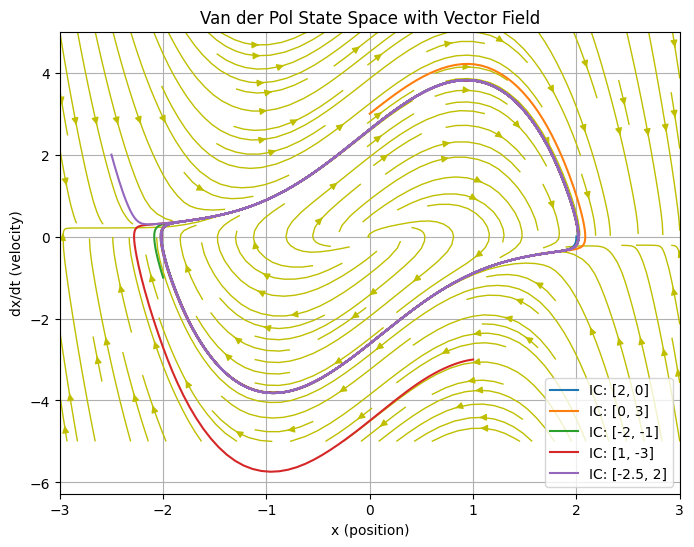

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the Van der Pol oscillator dynamics
mu = 2.0

def van_der_pol(t, X):
    x, v = X
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return [dxdt, dvdt]

# Final correction: meshgrid order and axis conventions for streamplot compatibility
x_vals = np.linspace(-3, 3, 25)
v_vals = np.linspace(-5, 5, 25)
X, V = np.meshgrid(x_vals, v_vals)

# Compute vector field
U = V
W = mu * (1 - X**2) * V - X
magnitude = np.sqrt(U**2 + W**2)
U /= magnitude + 1e-8
W /= magnitude + 1e-8

# Plot the vector field using streamplot (X: x-axis, V: y-axis)
plt.figure(figsize=(8, 6))
plt.streamplot(x_vals, v_vals, U, W, density=1.2, linewidth=1, arrowsize=1, color='y')

# Simulate trajectories from various initial conditions
initial_conditions = [[2, 0], [0, 3], [-2, -1], [1, -3], [-2.5, 2]]
t_span = (0, 30)
t_eval = np.linspace(*t_span, 2000)

for ic in initial_conditions:
    sol = solve_ivp(van_der_pol, t_span, ic, t_eval=t_eval)
    plt.plot(sol.y[0], sol.y[1], label=f'IC: {ic}')

plt.xlabel("x (position)")
plt.ylabel("dx/dt (velocity)")
plt.title("Van der Pol State Space with Vector Field")
plt.legend()
plt.grid(True)
plt.show()


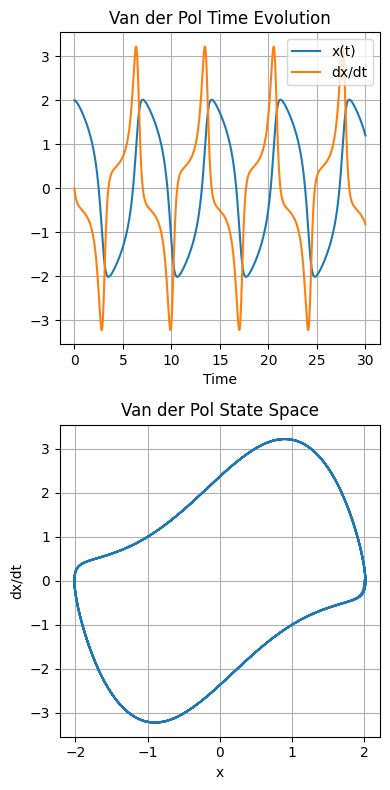

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- Part 1: Convert 3rd order ODE to 1st order system ---
# Example: d^3x/dt^3 + d^2x/dt^2 - dx/dt + x = 0

# Let:
# x1 = x
# x2 = dx/dt
# x3 = d^2x/dt^2

# Then:
# dx1/dt = x2
# dx2/dt = x3
# dx3/dt = -x3 - x2 + x1

def third_order_ode(t, X):
    x1, x2, x3 = X
    dx1 = x2
    dx2 = x3
    dx3 = -x3 - x2 + x1
    return [dx1, dx2, dx3]

t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 1000)
X0 = [1.0, 0.0, 0.0]  # Initial conditions for x, dx/dt, d^2x/dt^2

sol_third_order = solve_ivp(third_order_ode, t_span, X0, t_eval=t_eval)

# --- Part 2: Van der Pol oscillator (nonlinear) with phase plot ---
# Van der Pol: d^2x/dt^2 - mu(1 - x^2) dx/dt + x = 0
# Convert to first order system:
# Let x1 = x, x2 = dx/dt
# dx1/dt = x2
# dx2/dt = mu(1 - x1^2)*x2 - x1

mu = 1.5

def van_der_pol(t, X):
    x1, x2 = X
    dx1 = x2
    dx2 = mu * (1 - x1**2) * x2 - x1
    return [dx1, dx2]

X0_vdp = [2.0, 0.0]
sol_vdp = solve_ivp(van_der_pol, (0, 30), X0_vdp, t_eval=np.linspace(0, 30, 2000))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(4, 8))

# Phase portrait of Van der Pol
axs[1].plot(sol_vdp.y[0], sol_vdp.y[1])
axs[1].set_title("Van der Pol State Space")
axs[1].set_xlabel("x")
axs[1].set_ylabel("dx/dt")
axs[1].grid()

# Time evolution of Van der Pol
axs[0].plot(sol_vdp.t, sol_vdp.y[0], label="x(t)")
axs[0].plot(sol_vdp.t, sol_vdp.y[1], label="dx/dt")
axs[0].set_title("Van der Pol Time Evolution")
axs[0].set_xlabel("Time")
axs[0].legend()
axs[0].grid()

# Hide empty subplot
#axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set up for plotting state-space trajectories
from scipy.integrate import solve_ivp

# Time span for simulation
t_span = (0, 0.01)  # 10 ms
t_eval = np.linspace(*t_span, 5)

# --- 1. Single LC Tank ---

L1 = 1e-3  # 1 mH
C1 = 1e-6  # 1 uF
omega1 = 1 / np.sqrt(L1 * C1)

# State vector: [i1, v1]
def lc_tank(t, x):
    i1, v1 = x
    di1dt = -v1 / L1
    dv1dt = i1 / C1
    return [di1dt, dv1dt]

# Initial energy in the capacitor
x0_lc = [0.0, 1.0]  # initial current = 0, voltage = 1 V

sol_lc = solve_ivp(lc_tank, t_span, x0_lc, t_eval=t_eval)

# --- 2. Two Coupled LC Tanks ---

L = 1e-3
C = 1e-6
Cc = 0.1e-6  # Coupling capacitor

# State vector: [i1, v1, i2, v2]
def coupled_lc(t, x):
    i1, v1, i2, v2 = x
    # Effective C for each tank due to coupling
    dv1dt = i1 / C - (v1 - v2) / (Cc * C)
    di1dt = -v1 / L
    dv2dt = i2 / C - (v2 - v1) / (Cc * C)
    di2dt = -v2 / L
    return [di1dt, dv1dt, di2dt, dv2dt]

x0_coupled = [0.0, 1.0, 0.0, 0.0]  # energy only in first tank

sol_coupled = solve_ivp(coupled_lc, t_span, x0_coupled, t_eval=t_eval)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 1. Single LC Tank: v1 vs i1
axs[0].plot(sol_lc.y[1], sol_lc.y[0])
axs[0].set_title("State-Space Trajectory: Single LC Tank")
axs[0].set_xlabel("Capacitor Voltage v1 (V)")
axs[0].set_ylabel("Inductor Current i1 (A)")
axs[0].grid(True)
axs[0].axis('equal')

# 2. Coupled LC Tanks: v1 vs v2 (to show energy sloshing)
axs[1].plot(sol_coupled.y[1], sol_coupled.y[3])
axs[1].set_title("State-Space Projection: Coupled LC Tanks")
axs[1].set_xlabel("Voltage v1 (V)")
axs[1].set_ylabel("Voltage v2 (V)")
axs[1].grid(True)
axs[1].axis('equal')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 